# 取り組み

構造多型を反映したVCFを出力する

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if os.getcwd() != "/mnt/d/Research/DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


# 実験

In [3]:
%%bash
# stx2 deletion
# time python misc/quickstart.py

Traceback (most recent call last):
  File "/mnt/d/Research/DAJIN2/misc/quickstart.py", line 177, in <module>
    clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 24, in add_labels
    knockin_alleles = extract_knockin_loci(TEMPDIR)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/correct_knockin.py", line 26, in extract_knockin_loci
    fasta_alleles = list(Path(TEMPDIR, "fasta").iterdir())
  File "/home/kuno/miniconda/lib/python3.10/pathlib.py", line 1017, in iterdir
    for name in self._accessor.listdir(self):
FileNotFoundError: [Errno 2] No such file or directory: 'DAJINResults/.tempdir/test-stx2-deletion/fasta'

real	0m15.971s
user	0m8.421s
sys	0m2.306s


processing test-stx2-deletion...


In [3]:
import pysam

In [4]:
print(dir(pysam))

['AlignedRead', 'AlignedSegment', 'AlignmentFile', 'AlignmentHeader', 'BCFIndex', 'BCFIterator', 'BGZFile', 'BaseIndex', 'BaseIterator', 'BedProxy', 'CBACK', 'CDEL', 'CDIFF', 'CEQUAL', 'CHARD_CLIP', 'CINS', 'CMATCH', 'CPAD', 'CREF_SKIP', 'CSOFT_CLIP', 'FDUP', 'FMREVERSE', 'FMUNMAP', 'FPAIRED', 'FPROPER_PAIR', 'FQCFAIL', 'FREAD1', 'FREAD2', 'FREVERSE', 'FSECONDARY', 'FSUPPLEMENTARY', 'FUNMAP', 'FastaFile', 'Fastafile', 'FastqFile', 'FastqProxy', 'FastxFile', 'FastxRecord', 'GFF3Proxy', 'GTFProxy', 'GZIterator', 'GZIteratorHead', 'HFile', 'HTSFile', 'IndexedReads', 'IteratorColumn', 'IteratorRow', 'KEY_NAMES', 'NamedTupleProxy', 'Pileup', 'PileupColumn', 'PileupRead', 'Samfile', 'SamtoolsError', 'TabixFile', 'TabixIndex', 'TabixIterator', 'Tabixfile', 'TupleProxy', 'VCF', 'VCFProxy', 'VCFRecord', 'VariantContig', 'VariantFile', 'VariantHeader', 'VariantHeaderContigs', 'VariantHeaderMetadata', 'VariantHeaderRecord', 'VariantHeaderRecords', 'VariantHeaderSamples', 'VariantMetadata', 'Varia

In [2]:
from __future__ import annotations

import sys, os
from pathlib import Path

sys.path.append("/mnt/d/Research/DAJIN2")
os.chdir("/mnt/d/Research/DAJIN2")

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/del-stx2/barcode25.fq.gz",
    "examples/del-stx2/barcode30.fq.gz",
    "examples/del-stx2/design_stx2.fa",
    "test-stx2-deletion",
    "mm10",
    True,
    14,
)

print(f"processing {NAME}...")

processing test-stx2-deletion...


In [3]:
##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

In [7]:
ref_fasta = "DAJINResults/.tempdir/test-stx2-deletion/fasta/control.fasta"
query_bam = "DAJINResults/.tempdir/test-stx2-deletion/report/BAM/barcode25/barcode25_allele1_target_sv_35.971%.bam"
# pysam.mpileup("-f", f"{ref_fasta}", "-s", f"{query_bam}", "-o", "tmp_test.bcf")
# 30分たっても終わらなかった…

## pysam.mpileupは時間がかかりすぎて使えない -> 自作する


In [8]:
########################################################################
# Classify alleles
########################################################################

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)


In [11]:
########################################################################
# Clustering
########################################################################

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)


In [12]:
########################################################################
# Consensus call
########################################################################

RESULT_SAMPLE, cons_percentage, cons_sequence = consensus.call(clust_sample, FASTA_ALLELES)


In [13]:
count = defaultdict(int)
for res in RESULT_SAMPLE:
    count[res["NAME"]] += 1

print(count)

defaultdict(<class 'int'>, {'allele1_target_sv_35.971%': 1459, 'allele2_target_sv_31.903%': 1294, 'allele3_target_sv_31.681%': 1285, 'allele4_control_sv_0.197%': 8, 'allele5_target_mutated_0.173%': 7, 'allele6_control_mutated_0.049%': 2, 'allele7_inversion_sv_0.025%': 1})


## 連続同一塩基に対して、Nが置換されている
- コンセンサス配列を見ると`NNNNTTTTTNNN`となっていた。本来はすべてNであるのに、おそらくは`correct_revititive_deletions`のときにTに置き換わっている
- `correct_revititive_deletions`をなくすとどうなるか？

In [ ]:
################################################################################
# Export fasta files as single-FASTA format
################################################################################
for identifier, sequence in FASTA_ALLELES.items():
    contents = "\n".join([">" + identifier, sequence]) + "\n"
    output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
    output_fasta.write_text(contents)
###############################################################################
# Mapping with mappy
###############################################################################
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
########################################################################
# MIDSV conversion
########################################################################
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
###############################################################################
# Correct CSSPLITS
###############################################################################
# preprocess.correct_revititive_deletions.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [10]:
import midsv
midsv_sample = midsv.read_jsonl("DAJINResults/.tempdir/test-stx2-deletion/midsv/barcode25_splice_control.jsonl")

In [11]:
print(midsv_sample[0]["CSSPLIT"])

N,N,N,=C,=C,=A,=G,=G,=G,=T,=G,=T,=C,=T,=C,=A,=T,=A,=G,=T,=G,=T,=T,=T,=G,=A,=A,=G,=G,=C,=T,=C,=C,=T,=A,=A,=A,=T,=T,=G,=C,=C,=C,=A,=G,=T,=G,=T,=T,=C,=A,=G,=C,=T,=G,=G,=G,=G,=A,=A,=A,=G,=A,=C,=C,=A,=T,=C,=A,=G,=C,=T,=A,=G,=G,=C,=A,=G,=G,=A,=T,=C,=C,=A,=A,=A,=G,=G,=A,=T,=A,=A,=T,=G,=A,=G,=T,=G,=T,=G,=C,=C,=C,=C,=A,=T,=G,=G,=G,=A,=C,=T,=C,=T,=G,=G,=C,=T,=T,=A,=G,=C,=C,=G,=C,=A,=G,=C,=T,=C,=T,=A,=C,=C,=C,=T,=A,=A,=G,=C,=C,=C,=A,=C,=A,=G,=T,=T,=G,=A,=G,=G,=G,=G,=T,=A,=G,=T,=G,=G,=A,=T,=C,=T,=T,=G,=T,=G,=T,=T,=T,=G,=A,=G,=G,=A,=C,=A,=T,=T,=A,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=G,=A,=T,=T,=G,=G,=G,=A,=A,=A,=G,=T,=A,=G,=T,=G,=G,=T,=T,=G,=C,=T,=T,=G,=A,=T,=G,=G,=A,=G,=T,=T,=G,=G,=G,=C,=T,=A,=G,=C,=G,=A,=T,=G,=G,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=C,=T,=G,=G,=A,=G,=G,=C,=C,=A,=G,=T,=T,=G,=T,=G,=T,=G,=C,=C,=G,=C,=A,=T,=A,=C,=T,=A,=A,=C,=A,=G,=A,=G,=G,=A,=G,=T,=A,=A,=G,=C,=A,=C,=C,=A,=G,=C,=T,=A,=G,=A,=T,=T,=T,=T,=C,=A,=T,=T,=T,=C,=C,=T,=T,=A,=G,=G,=A,=T,=A,=T,=C,=T,=T,=T,=C,=T,=A,=A,=A,=T,=C,=T,=C,=A,=

In [ ]:
%%bash
### stx2 deletion
time python misc/quickstart.py

processing test-stx2-deletion...


Traceback (most recent call last):
  File "/mnt/d/Research/DAJIN2/misc/quickstart.py", line 177, in <module>
    clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 37, in add_labels
    scores_sample = annotate_score(cssplits_sample, mutation_score)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/annotate_score.py", line 9, in annotate_score
    if not mutation_score[i]:
IndexError: list index out of range

real	0m59.511s
user	1m3.693s
sys	0m16.899s


CalledProcessError: Command 'b'### stx2 deletion\ntime python misc/quickstart.py\n'' returned non-zero exit status 1.

### なぜかエラー

In [13]:
########################################################################
# Classify alleles
########################################################################

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)


In [14]:
########################################################################
# Clustering
########################################################################

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)


IndexError: list index out of range

In [15]:
from __future__ import annotations
from itertools import groupby
from copy import deepcopy
from collections import defaultdict
from pathlib import Path
import midsv

from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n, compress_insertion
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels
from src.DAJIN2.core.clustering.return_labels import return_labels


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES: dict, THREADS: int = 1) -> list[dict[str]]:
    paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
    cssplits_control_by_alleles = defaultdict(list)
    for path_midsv in paths_midsv:
        midsv_control = midsv.read_jsonl(path_midsv)
        allele = path_midsv.stem.split("_")[-1]
        cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_control_by_alleles[allele] = cssplits
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: (x["ALLELE"], x["SV"]))
    for (allele, _), group in groupby(classif_sample, key=lambda x: (x["ALLELE"], x["SV"])):
        cssplits_control = cssplits_control_by_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        cssplits_control = replace_both_ends_n(cssplits_control)
        cssplits_sample = replace_both_ends_n(cssplits_sample)
        cssplits_control = compress_insertion(cssplits_control)
        cssplits_sample = compress_insertion(cssplits_sample)
        mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
        scores_control = annotate_score(cssplits_control, mutation_score)
        scores_sample = annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = deepcopy(classif_sample)
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = deepcopy(clust_sample)
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = deepcopy(clust_sample)
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = deepcopy(clust_sample)
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [16]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
for path_midsv in paths_midsv:
    midsv_control = midsv.read_jsonl(path_midsv)
    allele = path_midsv.stem.split("_")[-1]
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    cssplits_control_by_alleles[allele] = cssplits
knockin_alleles = extract_knockin_loci(TEMPDIR)
labels_all = []
max_label = 0
classif_sample.sort(key=lambda x: (x["ALLELE"], x["SV"]))
for (allele, _), group in groupby(classif_sample, key=lambda x: (x["ALLELE"], x["SV"])):
    print(allele)
    cssplits_control = cssplits_control_by_alleles[allele]
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
    cssplits_control = replace_both_ends_n(cssplits_control)
    cssplits_sample = replace_both_ends_n(cssplits_sample)
    cssplits_control = compress_insertion(cssplits_control)
    cssplits_sample = compress_insertion(cssplits_sample)
    mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
    scores_control = annotate_score(cssplits_control, mutation_score)


control
control
inversion


IndexError: list index out of range

In [25]:
from copy import  deepcopy
cssplits = deepcopy(cssplits_control)

2341 2


In [20]:
scores = []
for cssplit in cssplits:
    score = [0]
    for i in range(1, len(cssplit) - 1):
        if not mutation_score[i]:
            score.append(0)
            continue
        kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
        score.append(mutation_score[i].get(kmer, 0))
    scores.append(score + [0])


IndexError: list index out of range

In [31]:
print(len(cssplits_control[0]), len(cssplits_sample[0]))

4309 4688


In [34]:
samp = [s for s in classif_sample if s["ALLELE"] == "inversion" and s["SV"] == True]

In [35]:
len(samp)

2

In [39]:
print(len(samp[0]["CSSPLIT"].split(",")))
print(len(samp[1]["CSSPLIT"].split(",")))

4688
4309


In [40]:
for seq in FASTA_ALLELES.values():
    print(len(seq))

3582
4309
4309


In [44]:
samp[0]["QNAME"]

'1e6ef194-6458-4bb2-a5c5-a6a728391b6e'

どうやらこのリードの長さがおかしいみたい

## midsvのエラー修正および再実行
- このリードは重複があるリードで、midsv変換のときに取り除かれていなかった。

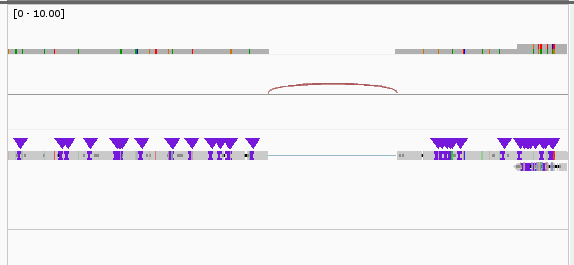
- `midsv`の`format.return_end_of_current_read`においてスプライシングシグナルをカウントしていなかったことが原因であったため、修正した
- 改めて`correct_revititive_deletions`を削除して実行

In [4]:
################################################################################
# Export fasta files as single-FASTA format
################################################################################
for identifier, sequence in FASTA_ALLELES.items():
    contents = "\n".join([">" + identifier, sequence]) + "\n"
    output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
    output_fasta.write_text(contents)
###############################################################################
# Mapping with mappy
###############################################################################
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
########################################################################
# MIDSV conversion
########################################################################
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.calc_midsv.output_midsv(TEMPDIR, path_sam)
###############################################################################
# Correct CSSPLITS
###############################################################################
# preprocess.correct_revititive_deletions.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [6]:
import midsv
midsv_sample = midsv.read_jsonl("DAJINResults/.tempdir/test-stx2-deletion/midsv/barcode25_splice_inversion.jsonl")
for s in midsv_sample:
    if s["QNAME"] == '1e6ef194-6458-4bb2-a5c5-a6a728391b6e':
        print("exist...")

In [5]:
%%bash
### stx2 deletion
time python misc/quickstart.py

processing test-stx2-deletion...



real	2m35.008s
user	3m34.976s
sys	1m32.406s


## ほかの遺伝型についても確認する

In [8]:
%%bash
rm -rf "DAJINResults/.tempdir/test-tyr-albino-01%/"
time python misc/quickstart.py

processing test-tyr-albino-01%...



real	3m26.383s
user	6m3.012s
sys	2m37.979s
Traceback (most recent call last):
  File "/mnt/d/Research/DAJIN2/misc/quickstart.py", line 177, in <module>
    clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 36, in add_labels
    scores_control = annotate_score(cssplits_control, mutation_score)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/annotate_score.py", line 9, in annotate_score
    if not mutation_score[i]:
IndexError: list index out of range

real	4m35.027s
user	3m57.621s
sys	0m7.752s


CalledProcessError: Command 'b'rm -rf "DAJINResults/.tempdir/test-tyr-albino-01%/"\ntime python misc/quickstart.py\n'' returned non-zero exit status 1.

In [9]:
#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "01"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    f"test-tyr-albino-{percent}%",
    "mm10",
    True,
    30,
)


In [10]:
##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)



In [11]:
classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

########################################################################
# Clustering
########################################################################

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)


IndexError: list index out of range

In [13]:
from __future__ import annotations
from itertools import groupby
from copy import deepcopy
from collections import defaultdict
from pathlib import Path
import midsv

from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n, compress_insertion
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels
from src.DAJIN2.core.clustering.return_labels import return_labels
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
for path_midsv in paths_midsv:
    midsv_control = midsv.read_jsonl(path_midsv)
    allele = path_midsv.stem.split("_")[-1]
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    cssplits_control_by_alleles[allele] = cssplits
knockin_alleles = extract_knockin_loci(TEMPDIR)
labels_all = []
max_label = 0
classif_sample.sort(key=lambda x: (x["ALLELE"], x["SV"]))
for (allele, _), group in groupby(classif_sample, key=lambda x: (x["ALLELE"], x["SV"])):
    print(allele)
    cssplits_control = cssplits_control_by_alleles[allele]
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
    cssplits_control = replace_both_ends_n(cssplits_control)
    cssplits_sample = replace_both_ends_n(cssplits_sample)
    cssplits_control = compress_insertion(cssplits_control)
    cssplits_sample = compress_insertion(cssplits_sample)
    mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
    scores_control = annotate_score(cssplits_control, mutation_score)


control


IndexError: list index out of range

In [15]:
print(allele)
print(len(cssplits_control))

control
9214


In [16]:
from copy import  deepcopy
cssplits = deepcopy(cssplits_control)

In [17]:
scores = []
for cssplit in cssplits:
    score = [0]
    for i in range(1, len(cssplit) - 1):
        if not mutation_score[i]:
            score.append(0)
            continue
        kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
        score.append(mutation_score[i].get(kmer, 0))
    scores.append(score + [0])


IndexError: list index out of range

In [21]:
midsv_control = midsv.read_jsonl(path_midsv)

In [22]:
[m["QNAME"] for m in midsv_control if len(m["CSSPLIT"].split(",")) == 2926]

['22ca01a3-97bd-461a-a33d-b4dd6959b383']

['=T',
 '=G',
 '=C',
 '=A',
 '=T',
 '=T',
 '=G',
 '=A',
 '=A',
 '=G',
 '=C',
 '=A',
 '=G',
 '=T',
 '=T',
 '=C',
 '=A',
 '=C',
 '=C',
 '=A',
 '=A',
 '=A',
 '=A',
 '=T',
 '=A',
 '=A',
 '=C',
 '=A',
 '=A',
 '=A',
 '=G',
 '=T',
 '=A',
 '=A',
 '=C',
 '=A',
 '=A',
 '=A',
 '=G',
 '=T',
 '=A',
 '=A',
 '=G',
 '=A',
 '=T',
 '=A',
 '=T',
 '=C',
 '=T',
 '=T',
 '=T',
 '=G',
 '=G',
 '=A',
 '=A',
 '=T',
 '=A',
 '=A',
 '=T',
 '=C',
 '=A',
 '=A',
 '=T',
 '=T',
 '=C',
 '=A',
 '=A',
 '=G',
 '=A',
 '=T',
 '=A',
 '=A',
 '=T',
 '=C',
 '=A',
 '=A',
 '=G',
 '=G',
 '=A',
 '=A',
 '=A',
 '=t',
 '=g',
 '=c',
 '=a',
 '=t',
 '=t',
 '=g',
 '=a',
 '=a',
 '=g',
 '=c',
 '=a',
 '=g',
 '=t',
 '=t',
 '=c',
 '=a',
 '=c',
 '=c',
 '=a',
 '=a',
 '=a',
 '=a',
 '=t',
 '=a',
 '=a',
 '=c',
 '=a',
 '=a',
 '=a',
 '=g',
 '=t',
 '=a',
 '=a',
 '=c',
 '=a',
 '=a',
 '=a',
 '=g',
 '=t',
 '=a',
 '=a',
 '=g',
 '=a',
 '=t',
 '=a',
 '=t',
 '=c',
 '=t',
 '=t',
 '=t',
 '=g',
 '=g',
 '=a',
 '=a',
 '=t',
 '=a',
 '=a',
 '=t',
 '=c',
 '=a',
 '=a',

## またエラーが出たので、midsvを更新（0.8.3 -> 0.8.4）

- 今回も重複リードが原因だった

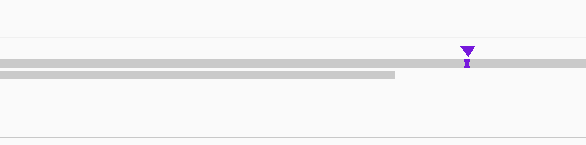

- スタートまたはエンドの位置が完全に同じリードはマイクロホモロジーによる重複ではなくリシークエンスであるため、除去することにした

In [23]:
%%bash
rm -rf "DAJINResults/.tempdir/test-tyr-albino-01%"
time python misc/quickstart.py

processing test-tyr-albino-01%...



real	5m52.337s
user	7m35.895s
sys	2m29.018s


In [24]:
%%bash
rm -rf "DAJINResults/.tempdir/test-ayabe-task1"
time python misc/quickstart.py

processing test-ayabe-task1...



real	1m23.869s
user	2m22.957s
sys	1m24.711s


In [25]:
%%bash
rm -rf "DAJINResults/.tempdir/test-knockout"
time python misc/quickstart.py

processing test-stx2-deletion...



real	2m36.187s
user	3m38.983s
sys	1m36.239s


# 結果


+ `correct_repetitive_deletions`を削除しても、ほぼ問題なく遺伝型解析ができた

# 次回の課題

+ [x] ~~点変異、欠失、ノックインのデザインで動くかを確認する~~
+ [x] ~~Clusteringのときの警告メッセージは無害なので消去する~~
+ [ ] right_loxpがいまいちな理由を考察する
    +  ~~[x] Ayabe-task1のpreprocessにおいて、329と1280の補正がされていない理由を検討する~~ -> distanceの閾値を下げた -> distanceの定義を変えた
+ [x] ~~distanceの閾値を下げた状態で、1%点変異が検出できるか~~
+ [x] ~~`correct_repetitive_deletions`を削除~~
+ [ ] VCFの出力
+ [ ] Flox insertionのアレル6のC->T変異は**クオリティが低いのでこれもシークエンスエラーの可能性が高い** (`20230215-distance-cosine.ipynb`)
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか
    + JS距離で抽出された変異部位だけを標的とする？
    + 両端のNを気にする必要がなくなる